In [1]:
import numpy as np
import sys
from sklearn.model_selection import train_test_split
import torch
from copy import deepcopy
import matplotlib.pyplot as plt

sys.path.insert(1, "../")
from data import load_narx_data, load_data, convert_to_narx
from model import Narx
from util_fun import calculate_error_nrms
from dataclasses import dataclass

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
N_EPOCHS = int(1e3)

In [6]:
def narx_sim_nrms(model, n_a, n_b, x_data, y_data, device=DEVICE, n_val_samples=3000):
    # init upast and ypast as lists.
    upast = [0] * n_b
    ypast = [0] * n_a

    x_data, y_data = [x[:n_val_samples] for x in [x_data, y_data]]
    ylist = []
    for unow in x_data.cpu().detach().numpy():
        # compute the current y given by f
        narx_input = torch.as_tensor(
            np.concatenate([upast, ypast])[None, :]).double()
        narx_input = narx_input.to(device)
        ynow = model.forward(narx_input).cpu().detach().item()

        # update past arrays
        upast.append(unow)
        upast.pop(0)
        ypast.append(ynow)
        ypast.pop(0)

        # save result
        ylist.append(ynow)

    NRMS = calculate_error_nrms(np.array(ylist), y_data)
    return x_data, y_data, np.array(ylist), NRMS


In [2]:
x, y = load_data()
x_train, x_val, y_train, y_val = train_test_split(x, y, shuffle=False)

In [4]:
na_list = [*range(3, 8)]
nb_list = [*range(14, 26)]

In [5]:
def narx_order_grid_search(
    x_train,
    y_train,
    x_val,
    y_val,
    na_list,
    nb_list,
    n_hidden_nodes=1000,
    n_epochs=N_EPOCHS,
    device=DEVICE,
):
    final_losses = np.ndarray((len(na_list), len(nb_list)))
    final_best_NRMSs = np.ndarray((len(na_list), len(nb_list)))
    simulation_NRMSs = np.ndarray((len(na_list), len(nb_list)))
    best_sim_NRMS = float("inf")
    best_sim_model = None
    for i, n_a in enumerate(na_list):
        for j, n_b in enumerate(nb_list):
            # construct NARX data
            x_train_temp, y_train_temp = convert_to_narx(x_train, y_train, n_a, n_b)
            x_val_temp, y_val_temp = convert_to_narx(x_val, y_val, n_a, n_b)
            x_train_temp, x_val_temp, y_train_temp, y_val_temp = [
                x.to(device)
                for x in [x_train_temp, x_val_temp, y_train_temp, y_val_temp]
            ]

            # initialise comparison values and results lists
            best_NRMS = float("inf")
            best_model = None
            best_sim_NRMS_temp = float("inf")
            best_sim_model_temp = None
            losses = []
            NRMSs = []
            best_NRMSs = []

            # initialise this run's model and optimizer
            model = Narx(x_train_temp.shape[1], n_hidden_nodes).to(device)
            optimizer = torch.optim.Adam(model.parameters())

            # train model
            for epoch in range(n_epochs):
                Loss = torch.mean((model(x_train_temp) - y_train_temp) ** 2)
                optimizer.zero_grad()
                Loss.backward()
                optimizer.step()
                # every so often, print status, check performance
                if (epoch + 1) % min((n_epochs // 20), 1000) == 0:
                    print(
                        f"current run: {n_a, n_b}, epoch: {epoch+1}, Loss: {Loss.item()}"
                    )
                    NRMS = calculate_error_nrms(model.forward(x_val_temp), y_val_temp)
                    if NRMS < best_NRMS:
                        best_NRMS = NRMS
                        best_model = deepcopy(model)
                        print(f"current RMS: {NRMS}, best RMS: {best_NRMS}")
                    losses.append(Loss.item())
                    NRMSs.append(NRMS)
                    best_NRMSs.append(best_NRMS)
                    _, _, _, sim_NRMS = narx_sim_nrms(
                        best_model, n_a, n_b, x_val, y_val, device
                    )
                    msg = f"current run: {n_a, n_b}, sim NRMS: {sim_NRMS}"
                    if sim_NRMS < best_sim_NRMS_temp:
                        best_sim_model_temp = deepcopy(best_model)
                        msg += f". This is better than last temp sim best:{best_sim_NRMS_temp} > {sim_NRMS}"
                        best_sim_NRMS_temp = sim_NRMS
                    print(msg)

            # store results
            final_losses[i, j] = losses[-1]
            final_best_NRMSs[i, j] = best_NRMSs[-1]
            _, _, _, sim_NRMS = narx_sim_nrms(
                best_sim_model_temp, n_a, n_b, x_val, y_val, device
            )
            simulation_NRMSs[i, j] = sim_NRMS
            msg = f"Finished run: {n_a, n_b}, sim NRMS: {simulation_NRMSs[i,j]}"
            if sim_NRMS < best_sim_NRMS:
                best_sim_model = deepcopy(best_sim_model_temp)
                msg += (
                    f". This is better than last sim best:{best_sim_NRMS} > {sim_NRMS}"
                )
                best_sim_NRMS = sim_NRMS
            print(msg)

    return best_sim_model, final_best_NRMSs, simulation_NRMSs

In [6]:
best_sim_model, final_best_NRMSs, simulation_NRMSs = narx_order_grid_search(
    x_train, y_train, x_val, y_val, na_list, nb_list
)

current run: (3, 14), epoch: 50, Loss: 0.05056197317069888
current RMS: 0.45450827933956656, best RMS: 0.45450827933956656
current run: (3, 14), sim NRMS: 0.0. This is better than last temp sim best:inf > 0.6938982348564975
current run: (3, 14), epoch: 100, Loss: 0.02612280223863182
current RMS: 0.3294867058485404, best RMS: 0.3294867058485404
current run: (3, 14), sim NRMS: 0.0. This is better than last temp sim best:0.6938982348564975 > 0.6642912166288157
current run: (3, 14), epoch: 150, Loss: 0.021881695275406916
current RMS: 0.30142622820884507, best RMS: 0.30142622820884507
current run: (3, 14), sim NRMS: 0.0
current run: (3, 14), epoch: 200, Loss: 0.018040792901468414
current RMS: 0.27377790795639395, best RMS: 0.27377790795639395
current run: (3, 14), sim NRMS: 0.0
current run: (3, 14), epoch: 250, Loss: 0.014215745531568034
current RMS: 0.24313497924222158, best RMS: 0.24313497924222158
current run: (3, 14), sim NRMS: 0.0
current run: (3, 14), epoch: 300, Loss: 0.0105793349349

C:\Users\Leo\AppData\Local\Temp\ipykernel_3708\13748030.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([0] + na_list)
C:\Users\Leo\AppData\Local\Temp\ipykernel_3708\13748030.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0] + na_list)


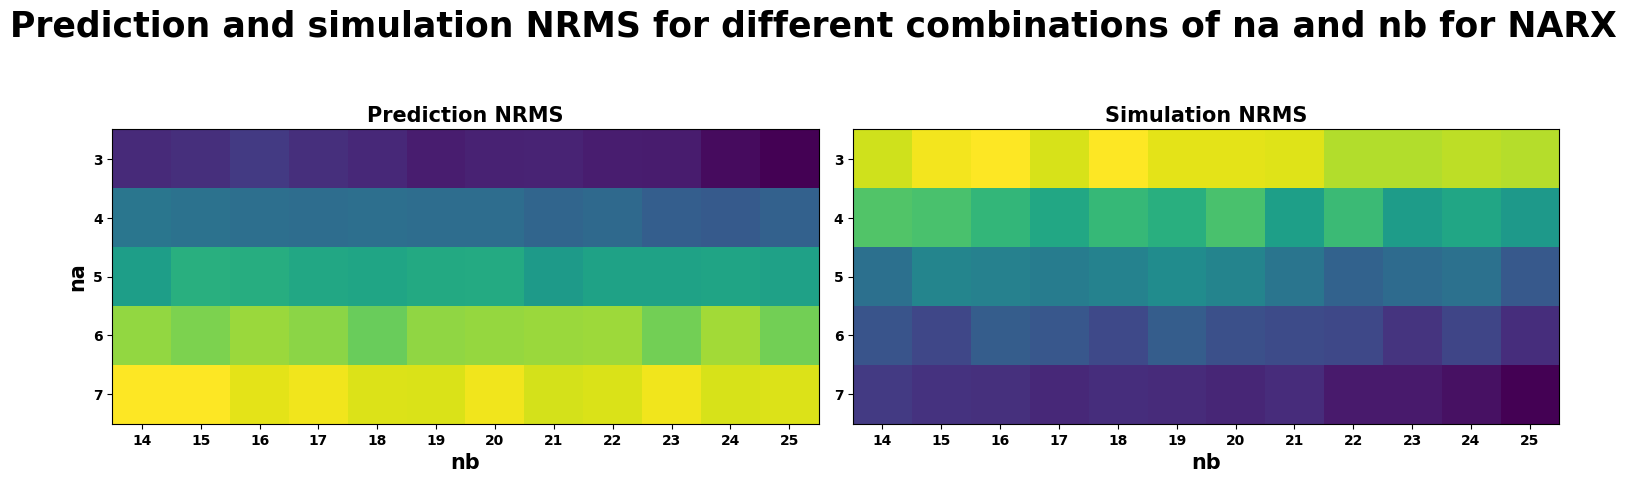

In [7]:
fs = 15
fig = plt.figure(figsize=(15, 5), layout="constrained")
ax1 = fig.add_subplot(121)
ax1.imshow(final_best_NRMSs, interpolation="none", norm="log")
ax2 = fig.add_subplot(122)
ax2.imshow(simulation_NRMSs, interpolation="none", norm="log")
ax1.set_title("Prediction NRMS", fontsize=fs)
ax2.set_title("Simulation NRMS", fontsize=fs)
fig.suptitle(
    "Prediction and simulation NRMS for different combinations of na and nb for NARX",
    fontsize=25,
)
ax1.set_ylabel("na", fontsize=fs)
ax1.set_xlabel("nb", fontsize=fs)
ax2.set_xlabel("nb", fontsize=fs)
ax1.set_yticklabels([0] + na_list)
ax1.set_xticks([*range(len(nb_list))], nb_list)
ax2.set_yticklabels([0] + na_list)
ax2.set_xticks([*range(len(nb_list))], nb_list)

In [8]:
params = np.zeros((len(na_list), len(nb_list), 2))
for i, n_a in enumerate(na_list):
    for j, n_b in enumerate(nb_list):
        params[i, j, :] = [n_a, n_b]

min_arg = np.unravel_index(
    final_best_NRMSs.argmin(keepdims=True), final_best_NRMSs.shape
)
best_na_pred, best_nb_pred = params[min_arg].ravel()
print(
    f"Best parameters by prediction NRMS: na= {best_na_pred}, nb= {best_nb_pred}, NRMS: {final_best_NRMSs[min_arg].ravel()}"
)
min_arg = np.unravel_index(
    simulation_NRMSs.argmin(keepdims=True), simulation_NRMSs.shape
)
best_na_sim, best_nb_sim = params[min_arg].ravel()
print(
    f"Best parameters by simulation NRMS: na= {best_na_sim}, nb= {best_nb_sim}, NRMS: {simulation_NRMSs[min_arg].ravel()}"
)

Best parameters by prediction NRMS: na= 3.0, nb= 25.0, NRMS: [0.02619148]
Best parameters by simulation NRMS: na= 7.0, nb= 25.0, NRMS: [0.26224655]


In [9]:
model = best_sim_model.to(DEVICE)

Text(0.5, 1.0, 'NRMS: 0.35837834826908543')

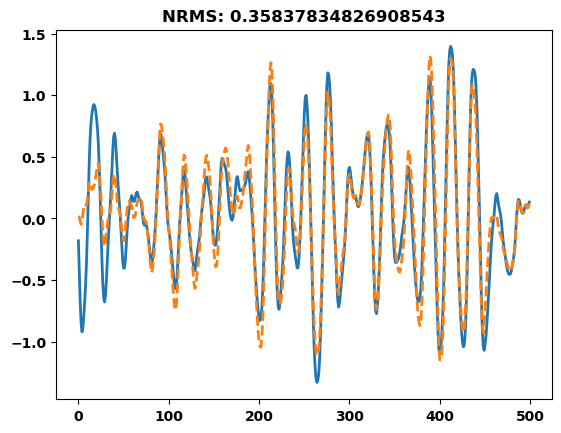

In [10]:
x_data, y_data, y_pred, NRMS = narx_sim_nrms(
    model, int(best_na_sim), int(best_nb_sim), x_val, y_val, n_val_samples=500
)
plt.plot(y_data, lw=2)
plt.plot(y_pred, "--", lw=2)
plt.title(f"NRMS: {NRMS}")
# plt.plot(y_data-y_pred)

In [8]:
def narx_nodes_grid_search(
    x_train,
    y_train,
    x_val,
    y_val,
    na,
    nb,
    n_hidden_list,
    n_epochs=N_EPOCHS,
    device=DEVICE,
):
    final_losses = []
    final_best_NRMSs = []
    simulation_NRMSs = []
    best_sim_NRMS = float("inf")
    best_sim_model = None

    # construct NARX data
    x_train_temp, y_train_temp = convert_to_narx(x_train, y_train, na, nb)
    x_val_temp, y_val_temp = convert_to_narx(x_val, y_val, na, nb)
    x_train_temp, x_val_temp, y_train_temp, y_val_temp = [
        x.to(device) for x in [x_train_temp, x_val_temp, y_train_temp, y_val_temp]
    ]
    for n_hidden_nodes in n_hidden_list:
        # initialise comparison values and results lists
        best_NRMS = float("inf")
        best_model = None
        losses = []
        NRMSs = []
        best_NRMSs = []

        # initialise this run's model and optimizer
        model = Narx(x_train_temp.shape[1], n_hidden_nodes).to(device)
        optimizer = torch.optim.Adam(model.parameters())

        # train model
        for epoch in range(n_epochs):
            Loss = torch.mean((model(x_train_temp) - y_train_temp) ** 2)
            optimizer.zero_grad()
            Loss.backward()
            optimizer.step()
            # every so often, print status, check performance
            if (epoch + 1) % min((n_epochs // 20), 1000) == 0:
                print(
                    f"current run: {n_hidden_nodes}, epoch: {epoch+1}, Loss: {Loss.item()}"
                )
                NRMS = calculate_error_nrms(model.forward(x_val_temp), y_val_temp)
                if NRMS < best_NRMS:
                    best_NRMS = NRMS
                    best_model = deepcopy(model)
                    print(f"current NRMS: {NRMS}, Nbest RMS: {best_NRMS}")
                losses.append(Loss.item())
                NRMSs.append(NRMS)
                best_NRMSs.append(best_NRMS)

        # store results
        final_losses.append(losses[-1])
        final_best_NRMSs.append(best_NRMSs[-1])
        _, _, _, sim_NRMS = narx_sim_nrms(best_model, na, nb, x_val, y_val, device)
        simulation_NRMSs.append(sim_NRMS)
        msg = f"current run: {n_hidden_nodes}, sim NRMS: {simulation_NRMSs[-1]}"
        if sim_NRMS < best_sim_NRMS:
            best_sim_model = deepcopy(best_model)
            msg += f". This is better than last sim best:{best_sim_NRMS} > {sim_NRMS}"
            best_sim_NRMS = sim_NRMS
        print(msg)

    return best_sim_model, final_best_NRMSs, simulation_NRMSs

In [9]:
n_hidden_list = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
na, nb = 7, 25
best_sim_model, final_best_NRMSs, simulation_NRMSs = narx_nodes_grid_search(
    x_train, y_train, x_val, y_val, na, nb, n_hidden_list
)

current run: 10, epoch: 50, Loss: 0.1192721380201451
current NRMS: 0.7131685802079936, Nbest RMS: 0.7131685802079936
current run: 10, epoch: 100, Loss: 0.06616781002455649
current NRMS: 0.5374515115418395, Nbest RMS: 0.5374515115418395
current run: 10, epoch: 150, Loss: 0.050612632225969525
current NRMS: 0.4721453203614261, Nbest RMS: 0.4721453203614261
current run: 10, epoch: 200, Loss: 0.04263611421416368
current NRMS: 0.4347072866926071, Nbest RMS: 0.4347072866926071
current run: 10, epoch: 250, Loss: 0.03445171795233561
current NRMS: 0.39287866198951876, Nbest RMS: 0.39287866198951876
current run: 10, epoch: 300, Loss: 0.025636025802453572
current NRMS: 0.3419807812800938, Nbest RMS: 0.3419807812800938
current run: 10, epoch: 350, Loss: 0.01716789219021135
current NRMS: 0.28440508558531674, Nbest RMS: 0.28440508558531674
current run: 10, epoch: 400, Loss: 0.010358431377391725
current NRMS: 0.22741676007301387, Nbest RMS: 0.22741676007301387
current run: 10, epoch: 450, Loss: 0.0059

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.23 GiB (GPU 0; 4.00 GiB total capacity; 2.29 GiB already allocated; 553.00 MiB free; 2.31 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
plt.semilogx(n_hidden_list, final_best_NRMSs)
plt.semilogx(n_hidden_list, simulation_NRMSs)
plt.legend(["Prediction NRMS", "Simulation NRMS"])

NameError: name 'n_hidden_list' is not defined